In [1]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import psycopg2

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import functions as F
from pyspark.ml.clustering import KMeans

In [75]:
#получаем список файлов для папки
folder_path = r'C:\Users\Tasha\PycharmProjects\FU_6-1\data\data'
file_names = []

for file_name in os.listdir(folder_path):
    if file_name.endswith('.geojson'):
        file_names.append(os.path.join(folder_path, file_name))

print(file_names)

['C:\\Users\\Tasha\\PycharmProjects\\FU_6-1\\data\\data\\altaiskii-krai.geojson', 'C:\\Users\\Tasha\\PycharmProjects\\FU_6-1\\data\\data\\amurskaia-oblast.geojson', 'C:\\Users\\Tasha\\PycharmProjects\\FU_6-1\\data\\data\\arkhangelskaia-oblast.geojson', 'C:\\Users\\Tasha\\PycharmProjects\\FU_6-1\\data\\data\\astrakhanskaia-oblast.geojson', 'C:\\Users\\Tasha\\PycharmProjects\\FU_6-1\\data\\data\\belgorodskaia-oblast.geojson', 'C:\\Users\\Tasha\\PycharmProjects\\FU_6-1\\data\\data\\brianskaia-oblast.geojson', 'C:\\Users\\Tasha\\PycharmProjects\\FU_6-1\\data\\data\\chechenskaia-respublika.geojson', 'C:\\Users\\Tasha\\PycharmProjects\\FU_6-1\\data\\data\\cheliabinskaia-oblast.geojson', 'C:\\Users\\Tasha\\PycharmProjects\\FU_6-1\\data\\data\\chukotskii-avtonomnyi-okrug.geojson', 'C:\\Users\\Tasha\\PycharmProjects\\FU_6-1\\data\\data\\chuvashskaia-respublika-chuvashiia.geojson', 'C:\\Users\\Tasha\\PycharmProjects\\FU_6-1\\data\\data\\evreiskaia-avtonomnaia-oblast.geojson', 'C:\\Users\\Tasha\\

In [89]:
# Список для хранения данных из файлов
data = []

# Чтение данных из каждого файла и добавление их в список
for file_name in file_names:
    with open(file_name, 'r', encoding='utf-8') as file:
        file_data = json.load(file)
        for feature in file_data['features']:
            properties = feature['properties']
            datetime = properties['datetime']
            lat = feature['geometry']['coordinates'][1]
            long = feature['geometry']['coordinates'][0]
            dead_count = properties['dead_count']
            injured_count = properties['injured_count']
            light = properties['light']
            weather = properties.get('weather')
            road_conditions = properties.get('road_conditions')
            location = properties.get('parent_region')

            data.append([datetime, lat, long, dead_count, injured_count, light, weather, road_conditions, location])

# Создание датафрейма
df = pd.DataFrame(data, columns=['datetime', 'lat', 'long', 'dead_count', 'injured_count', 'light', 'weather', 'road_conditions', 'location'])

In [90]:
df.head(10)

,datetime,lat,long,dead_count,injured_count,light,weather,road_conditions,location
0,2023-05-31 15:40:00,53.333300,83.656500,0,1,Светлое время суток,[Ясно],[Сухое],Алтайский край
1,2023-05-24 19:30:00,53.391200,83.787900,0,1,Светлое время суток,[Ясно],[Сухое],Алтайский край
2,2015-09-16 13:00:00,53.345833,83.666389,0,1,Светлое время суток,[Пасмурно],[Сухое],Алтайский край
3,2017-08-25 15:30:00,53.197060,83.396880,0,1,Светлое время суток,[Ясно],[Сухое],Алтайский край
4,2021-05-29 19:40:00,53.376400,83.714200,0,1,Светлое время суток,[Ясно],"[Сухое, Отсутствие, плохая различимость горизо...",Алтайский край
5,2021-05-25 16:40:00,53.343071,83.794366,0,1,Светлое время суток,[Ясно],"[Сухое, Отсутствие, плохая различимость горизо...",Алтайский край
6,2021-02-22 13:50:00,53.290476,83.708739,0,3,Светлое время суток,[Ясно],[Обработанное противогололедными материалами],Алтайский край
7,2022-01-23 19:20:00,53.379297,83.718234,0,1,"В темное время суток, освещение включено",[Ясно],"[Сухое, Недостатки зимнего содержания, Неправи...",Алтайский край
8,2021-04-11 13:30:00,53.357051,83.658732,0,1,Светлое время суток,[Ясно],"[Мокрое, Отсутствие, плохая различимость гориз...",Алтайский край
9,2021-04-20 18:55:00,53.343391,83.704684,0,1,Светлое время суток,[Ясно],"[Сухое, Отсутствие, плохая различимость горизо...",Алтайский край


In [91]:
df.shape

(1355650, 9)

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1355650 entries, 0 to 1355649
Data columns (total 9 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   datetime         1355650 non-null  object 
 1   lat              1344906 non-null  float64
 2   long             1344906 non-null  float64
 3   dead_count       1355650 non-null  int64  
 4   injured_count    1355650 non-null  int64  
 5   light            1355650 non-null  object 
 6   weather          1355650 non-null  object 
 7   road_conditions  1355650 non-null  object 
 8   location         1355650 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 93.1+ MB


In [93]:
#настроим локально сервер pyspark

master = 'local[4]'

spark = SparkSession.builder  \
    .master(master)  \
    .appName('Spark_FU6_1')  \
    .getOrCreate()

spark


In [94]:
#обработаем колонку с данными по дорогам
for i, conditions in enumerate(df['road_conditions']):
    # проверить на нан
    if conditions is not None:
        # удалить скобки в конце и в начале строки
        conditions = conditions[0].replace('[', '').replace(']', '')
        # разделить строку и получить первое слово
        first_word = conditions.split(',')[0].strip()
        # обновить значение в столбце
        df.at[i, 'road_conditions'] = first_word

In [95]:
#проверим результат
df['road_conditions'][:10]

0                                          Сухое
1                                          Сухое
2                                          Сухое
3                                          Сухое
4                                          Сухое
5                                          Сухое
6    Обработанное противогололедными материалами
7                                          Сухое
8                                         Мокрое
9                                          Сухое
Name: road_conditions, dtype: object

In [96]:
#обработать колонку с погодой
df['weather'] = df['weather'].astype(str).str.replace('[', '').str.replace(']', '').str.strip("'")

In [97]:
#отберем датасет только с условиями  Road Conditions == Мокрое как наиболее вероятная причина ДТП
filtered_df = df[df['road_conditions'] == "Мокрое"]
print('Filtered _df.shape:', filtered_df.shape)

filtered_df.head()

Filtered _df.shape: (256196, 9)


,datetime,lat,long,dead_count,injured_count,light,weather,road_conditions,location
8,2021-04-11 13:30:00,53.357051,83.658732,0,1,Светлое время суток,Ясно,Мокрое,Алтайский край
12,2021-04-09 21:40:00,53.379303,83.724564,0,1,"В темное время суток, освещение включено",Ясно,Мокрое,Алтайский край
13,2021-04-05 17:20:00,53.380602,83.688548,0,1,Светлое время суток,Ясно,Мокрое,Алтайский край
23,2021-03-26 12:35:00,53.343948,83.781084,0,1,Светлое время суток,Пасмурно,Мокрое,Алтайский край
24,2021-03-19 12:20:00,53.339624,83.669879,0,1,Светлое время суток,Ясно,Мокрое,Алтайский край


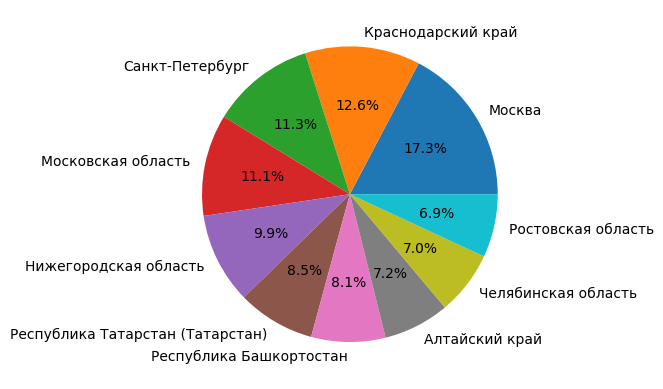

In [99]:
#посмотрим основные локации
location_count = df['location'].value_counts()[:10]

plt.pie(location_count, labels=location_count.index, autopct='%1.1f%%')
plt.show()

In [100]:
#сохраняем данные в датасет
filtered_df.to_csv('filtered_df.csv')

In [106]:
#смотрим данные в спарке
df = spark.read.csv('filtered_df.csv', inferSchema= True, header=True, sep=',')

In [108]:
df.show(5, truncate=True)

+---+-------------------+---------+---------+----------+-------------+--------------------+--------+---------------+--------------+
|_c0|           datetime|      lat|     long|dead_count|injured_count|               light| weather|road_conditions|      location|
+---+-------------------+---------+---------+----------+-------------+--------------------+--------+---------------+--------------+
|  8|2021-04-11 13:30:00|53.357051|83.658732|         0|            1| Светлое время суток|    Ясно|         Мокрое|Алтайский край|
| 12|2021-04-09 21:40:00|53.379303|83.724564|         0|            1|В темное время су...|    Ясно|         Мокрое|Алтайский край|
| 13|2021-04-05 17:20:00|53.380602|83.688548|         0|            1| Светлое время суток|    Ясно|         Мокрое|Алтайский край|
| 23|2021-03-26 12:35:00|53.343948|83.781084|         0|            1| Светлое время суток|Пасмурно|         Мокрое|Алтайский край|
| 24|2021-03-19 12:20:00|53.339624|83.669879|         0|            1| Светл

In [118]:
#векторизация данных
input_columns = ['lat', 'long']

vec_assembler = VectorAssembler(inputCols=input_columns,
                                outputCol='features',
                                handleInvalid='skip')
final_data = vec_assembler.transform(df)
final_data.select(F.col('features')).show(5, truncate=False)

+---------------------+
|features             |
+---------------------+
|[53.357051,83.658732]|
|[53.379303,83.724564]|
|[53.380602,83.688548]|
|[53.343948,83.781084]|
|[53.339624,83.669879]|
+---------------------+
only showing top 5 rows



In [119]:
#применим модель кластерии для получения центров кластеров k=500
kmeans = KMeans(featuresCol='features',
                predictionCol='clusters',
                distanceMeasure='euclidean',
                initMode='k-means||',
                seed=1881,
                maxIter=100,
                k=500)
model=kmeans.fit(final_data)

In [120]:
center_df = model.transform(final_data).select('clusters', 'lat', 'long', 'dead_count', 'location')
center_df.show(5, truncate=False)

+--------+---------+---------+----------+--------------+
|clusters|lat      |long     |dead_count|location      |
+--------+---------+---------+----------+--------------+
|35      |53.357051|83.658732|0         |Алтайский край|
|35      |53.379303|83.724564|0         |Алтайский край|
|35      |53.380602|83.688548|0         |Алтайский край|
|35      |53.343948|83.781084|0         |Алтайский край|
|35      |53.339624|83.669879|0         |Алтайский край|
+--------+---------+---------+----------+--------------+
only showing top 5 rows



In [151]:
#датафрейм кластеров
centers = pd.DataFrame(model.clusterCenters(), columns=['lat','long'])
centers.head()

,lat,long
0,55.566874,37.656738
1,55.576039,84.595819
2,61.708126,50.747708
3,43.155161,131.996392
4,59.930903,30.351533


In [152]:
centers.shape

(500, 2)

In [153]:
#сохраним данные в датафрейм 
centers.to_csv('centers.csv')

In [172]:
#перенос данных после обработки в БД PostgreSQL
try:
    # пытаемся подключиться к базе данных
    conn = psycopg2.connect(dbname='centers', user='postgres', password="somnambula20", host="127.0.0.1", port="5432")
except:
    # в случае сбоя подключения будет выведено сообщение в STDOUT
    print('Can`t establish connection to database')

In [173]:
cursor = conn.cursor()
cursor.execute("SELECT EXISTS (SELECT FROM information_schema.tables WHERE table_name = 'cluster_center')")
exists = cursor.fetchone()[0]

if exists:
    print("Таблица cluster_center существует")
else:
    print("Таблица cluster_center не существует")


Таблица cluster_center существует


In [174]:
#добавление данных в базу PostgreSQL

try:
    cursor = conn.cursor()

    with conn.cursor() as cursor:
        with open ('centers.csv', 'r') as f:
            next(f)  # Пропускаем первую строку
            cursor.copy_from(f, 'cluster_center', sep=',')
    print(f'данные добавлены')

except Exception as _ex:
    print('[INFO] Ошибка в PostgreSQL', _ex)

данные добавлены


In [176]:
try:
    cursor = conn.cursor()

    cursor.execute("SELECT * FROM cluster_center")
    rows = cursor.fetchall()

    for row in rows:
        print(row)

except psycopg2.Error as e:
    print('Ошибка в PostgreSQL:', e)


(0, Decimal('55.56687422262358'), Decimal('37.65673830006768'))
(1, Decimal('55.57603945957448'), Decimal('84.59581917872345'))
(2, Decimal('61.70812635536306'), Decimal('50.74770811917675'))
(3, Decimal('43.15516064812776'), Decimal('131.9963918535243'))
(4, Decimal('59.93090263527536'), Decimal('30.35153348308078'))
(5, Decimal('1.1983559016393441'), Decimal('1.1618006229508195'))
(6, Decimal('44.63218847351697'), Decimal('39.98729930826273'))
(7, Decimal('56.34248187844037'), Decimal('41.31846299311924'))
(8, Decimal('53.47606720539147'), Decimal('55.87734879332476'))
(9, Decimal('51.52338925071228'), Decimal('46.04066277314812'))
(10, Decimal('53.0799611690648'), Decimal('158.544750577338'))
(11, Decimal('56.222777280701756'), Decimal('101.63883767982458'))
(12, Decimal('53.685220876106186'), Decimal('87.9223353628319'))
(13, Decimal('50.3039018291457'), Decimal('127.52123028140709'))
(14, Decimal('55.31235178787879'), Decimal('67.22746096969696'))
(15, Decimal('56.202687578124994'

In [ ]:
#закрытие коннекта с БД
cursor.close()
conn.close()